# Compute the Average Gradients of the Posterior Mean

- average over the average gradient, per WA.

- Added a Method to the GPflow GPR class


In [211]:
from __future__ import print_function, absolute_import

import gpflow
import numpy as np
import tensorflow as tf

from gpflow.models import GPR
from gpflow.decors import autoflow

float_type = gpflow.settings.dtypes.float_type

class GPR_with_grad(GPR):
    def __init__(self, X, Y, kern):
        GPR.__init__(self, X, Y, kern)
        #print("m = GPR with posterior gradients")

    @autoflow((float_type, [None, None]))
    def compute_posterior_grad_at(self, Xnew):
        """
        Compute the gradient of the posterior mean function at a specific valuem, Xnew.
        """
        pred_mean, pred_var = self._build_predict(Xnew)
        return tf.gradients(pred_mean, Xnew)

In [355]:
import os
import copy
import numpy as np
import pandas as pd
import getpass
import _pickle as pickle
import gpflow
import pylab as plt
%matplotlib inline
import itertools
import random
from sklearn.model_selection import KFold

datasets = '/home/'+ getpass.getuser() +'/Datasets/'
print(datasets)

## This data is the occupation skills vectors, weighted by Task Importance per DWA
file_name = 'tasks_by_skills_2018_v3.p'
p = os.path.join(datasets, 'FoEmployment/Analysis_of_ONET_Tasks', file_name)
with open(p, 'rb') as f:
    data = pickle.load(f, encoding='latin1')

## This data is further weighted by Task Importance per Occupation
#/home/scpd/Datasets/FoEmployment/Analysis_of_ONET_Tasks/tasks_by_skills_v3_o.p
p = os.path.join(datasets, 'FoEmployment/Analysis_of_ONET_Tasks/tasks_by_skills_2018_v3_o.p')
with open(p, 'rb') as f:
    data_o = pickle.load(f, encoding='latin1')

#Misc settings
ms = 11  # marker size in plots
random.seed =  6   # random seed

/home/scpd/Datasets/


In [88]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def plot_bars(RMS_reps, title, labels):
    
    RMS_reps = np.vstack(RMS_reps)
    means = RMS_reps.mean(axis=0)
    stds = RMS_reps.std(axis=0)

    colours = ["teal"]*(len(labels)-1) + ["green"]
    xbar = range(len(means))

    fig, ax = plt.subplots(figsize=(20, 8))
    rects = ax.bar(xbar, means, color = colours,  yerr=stds)
    ax.set_xticks(xbar)
    ax.set_xticklabels(labels, rotation=70)
    ax.set_ylabel('Average RMSE')
#     ax.set_ylim([0,0.8])
    ax.set_xlabel('Kernel choice')
    ax.set_title(title)
#     autolabel(rects1)
    """Attach a text label above each bar displaying its height"""
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + 0.2+ rect.get_width()/2., 1.05*height,'%0.3f' % height, ha='center', va='bottom')
    plt.show()


In [317]:
## Unit Normalise train and test :)
# test_n = (test[cols]-X[cols].mean())/X[cols].std()
# normalized_test = pd.merge(test[['DWA ID', 'DWA GT Rating']], test_n, how='left', left_index=True, right_index=True)

# X_n = (X[cols]-X[cols].mean())/X[cols].std()
# norm_X = pd.merge(X[['DWA ID', 'DWA GT Rating']], X_n, how='left', left_index=True, right_index=True)
# X = norm_X.copy()

def model(x_train, y_train, k, evaluate=None):
    m = GPR_with_grad(x_train, y_train, kern=k)
    gpflow.train.ScipyOptimizer().minimize(m)
    
    if evaluate == None: return None 
    ll = m.compute_log_likelihood()
    print(">>",ll)
    if -ll > 0:
        (x_valid,y_valid) = evaluate
        (pred, val) = m.predict_f(x_valid)
        return rmse(pred, y_valid)
    else:
        return np.nan

def predict_on_held_out_set(X, y, cols, cv_folds = 10, in_dims=120): 
    
# Create a random Validation set
#     msk = [i for i in range(X.shape[0])]
#     random.shuffle(msk)
#     n_validation_set = int(np.floor(X.shape[0]*val_size))
#     x_train = X.iloc[msk[n_validation_set:]][cols].as_matrix()
#     x_valid = X.iloc[msk[:n_validation_set]][cols].as_matrix()
#     y_train = y.values[msk[n_validation_set:]].reshape(x_train.shape[0], 1)
#     y_valid = y.values[msk[:n_validation_set]].reshape(n_validation_set, 1)

    # Actual K-fold CV
    k_fold = KFold(n_splits=10)
    scores = []
    
    for train_indices, test_indices in k_fold.split(X[cols].as_matrix()):
        x_train = X.iloc[train_indices][cols].as_matrix()
        x_valid = X.iloc[test_indices][cols].as_matrix()
        y_train = y.values[train_indices].reshape(x_train.shape[0], 1)
        y_valid = y.values[test_indices].reshape(x_valid.shape[0], 1)

        per_fold = []
       
        # RBF Kernel
        k = gpflow.kernels.RBF(in_dims)
        per_fold.append(model(x_train, y_train, k, (x_valid, y_valid)))
        
        # ArcCosine Kernel        
        k = gpflow.kernels.ArcCosine(in_dims)
        per_fold.append(model(x_train, y_train, k, (x_valid, y_valid)))
        
        # Linear Kernel        
#         k = gpflow.kernels.Linear(in_dims)
#         per_fold.append(model(x_train, y_train, k, (x_valid, y_valid)))
        
        # Average 
        per_fold.append(rmse(y_valid, np.mean(y_valid)))
        
        scores.append(per_fold)
    return scores

(X, test, y) = data_o
# cols = test.columns[2:]

# Subset of the features - to assess whether arcCosine will converge
skills = test.columns[2:2+35]
know = test.columns[37:37+33]
ability = test.columns[37+33:]

cols = skills #.append(know)
in_dims = cols.shape[0]

scores = predict_on_held_out_set(X, y, cols, 10, in_dims)
print(scores)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 263.063223
  Number of iterations: 20
  Number of functions evaluations: 34
>> -263.06322295387747
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 221.126431
  Number of iterations: 46
  Number of functions evaluations: 121
>> -221.12643083594105
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 263.077338
  Number of iterations: 21
  Number of functions evaluations: 30
>> -263.0773376855823
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 220.469816
  Number of iterations: 67
  Number of functions evaluations: 81
>> -220.46981613282568
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_R

[0.4884404289694275, 0.4293018843044533, 0.6018897470579718]
[0.445446296013955, 0.4514859712779501, 0.49152037927104]
[0.6670679599317557, 0.590971437000127, 0.586682434158167]
[0.5800380652842451, 0.4331764462302665, 0.662500789363231]
[0.5705600305162876, 0.501866954869545, 0.5747172924607729]
[0.5150635899660924, 0.4418306045547312, 0.535689929926429]
[0.5458944360606771, 0.5181618059266246, 0.5294085212682595]
[0.6170612375797397, 0.5817106437080631, 0.505399226407528]
[0.65060706470155, 0.5277859272483598, 0.5335400688085202]
[0.6862625115259908, 0.5818930327670038, 0.7983775268713773]


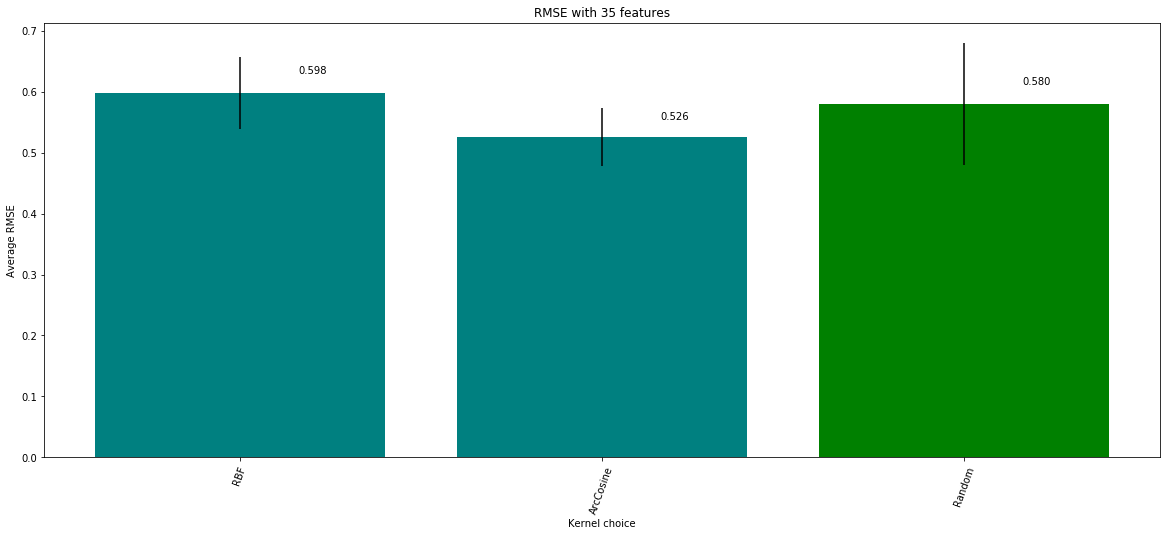

In [324]:
for i in scores:
    print(i)

# labels = ["RBF", "ArcCosine", "Linear", "Random"]
labels = ["RBF", "ArcCosine", "Random"]

plot_bars(scores[4:], "RMSE with %s features" % len(cols), labels)


# Train just one model to calculate average gradients: 

In [358]:
(X, test, y) = data_o

# Subset of the features - to assess whether arcCosine will converge
skills = test.columns[2:2+35]
know = test.columns[37:37+33]
ability = test.columns[37+33:]

# cols = skills #.append(know)
cols = test.columns[2:]   # All Attributes 
in_dims = cols.shape[0]

x_train = X[cols].as_matrix()
y_train = y.values.reshape(x_train.shape[0], 1)

# RBF Kernel
k = gpflow.kernels.RBF(in_dims)

# # ArcCosine Kernel        
# k = gpflow.kernels.ArcCosine(in_dims)

m = GPR_with_grad(x_train, y_train, kern=k)
gpflow.train.ScipyOptimizer().minimize(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 284.867284
  Number of iterations: 21
  Number of functions evaluations: 32


In [359]:
df['IWA ID'] = df['DWA ID'].str.slice(0,-4)    # create IWA ID
df['WA ID'] = df['DWA ID'].str.slice(0,-8)     # create WA ID

WAref = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/Work Activities.txt'), sep='\t')[['Element ID', 'Element Name']]
WAref.rename(columns = {'Element ID':'WA ID', 'Element Name':'WA Title'}, inplace = True)
WAref.drop_duplicates(inplace=True)


In [361]:
local_AGs = {}
counts = {}

for wa in df['IWA ID'].unique():
    coefs_for_all[wa] = []
    df_subset = df[df['IWA ID'] == wa][cols].values
    n = df_subset.shape[0]
    y_subset = y[df['IWA ID'] == wa].reshape(n,)
    counts[wa] = n
    
    grads_at = m.compute_posterior_grad_at(df_subset)[0]
    a_grad = grads_at.mean(axis=0)
    
    local_AGs[wa] = [ (cols[cnt], cnt, i)  for cnt, i in enumerate(a_grad)]
#     print(local_AGs[wa])


/home/scpd/Software/anaconda3/envs/GPflow3.5/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [362]:
counts

{'4.A.1.a.1.I01': 2,
 '4.A.1.a.1.I02': 4,
 '4.A.1.a.1.I04': 1,
 '4.A.1.a.1.I05': 1,
 '4.A.1.a.1.I06': 1,
 '4.A.1.a.1.I12': 1,
 '4.A.1.a.1.I14': 1,
 '4.A.1.a.1.I20': 1,
 '4.A.1.a.1.I23': 3,
 '4.A.1.a.2.I01': 4,
 '4.A.1.a.2.I02': 3,
 '4.A.1.a.2.I05': 2,
 '4.A.1.a.2.I06': 5,
 '4.A.1.a.2.I07': 4,
 '4.A.1.a.2.I09': 1,
 '4.A.1.a.2.I11': 1,
 '4.A.1.b.1.I01': 2,
 '4.A.1.b.2.I03': 1,
 '4.A.1.b.2.I04': 1,
 '4.A.1.b.2.I05': 5,
 '4.A.1.b.2.I06': 4,
 '4.A.1.b.2.I07': 4,
 '4.A.1.b.2.I09': 1,
 '4.A.1.b.2.I10': 1,
 '4.A.1.b.2.I12': 3,
 '4.A.1.b.3.I01': 3,
 '4.A.1.b.3.I04': 1,
 '4.A.2.a.1.I03': 3,
 '4.A.2.a.1.I04': 1,
 '4.A.2.a.1.I09': 1,
 '4.A.2.a.2.I01': 2,
 '4.A.2.a.2.I02': 2,
 '4.A.2.a.2.I03': 1,
 '4.A.2.a.2.I04': 1,
 '4.A.2.a.2.I05': 1,
 '4.A.2.a.3.I01': 1,
 '4.A.2.a.3.I04': 1,
 '4.A.2.a.4.I02': 1,
 '4.A.2.a.4.I03': 1,
 '4.A.2.a.4.I05': 1,
 '4.A.2.a.4.I06': 1,
 '4.A.2.a.4.I07': 3,
 '4.A.2.a.4.I08': 1,
 '4.A.2.a.4.I11': 1,
 '4.A.2.a.4.I12': 1,
 '4.A.2.b.1.I01': 2,
 '4.A.2.b.1.I03': 1,
 '4.A.2.b.1.I


 4.A.3.a.2 Handling and Moving Objects
positive
('Sociology and Anthropology', 64, 0.3492450807885192)
('Therapy and Counseling', 66, 0.2609368299364056)
('Explosive Strength', 76, 0.2281440053137239)
negative
('Production and Processing', 60, -0.5285545546151319)
('Mechanical', 55, -0.4491785394266974)
('Repairing', 24, -0.37588536206075457)

 4.A.4.b.4 Guiding, Directing, and Motivating Subordinates
positive
('Depth Perception', 73, 0.5869203650940498)
('Multilimb Coordination', 91, 0.5346725791384909)
('Explosive Strength', 76, 0.5125887232402693)
negative
('Production and Processing', 60, -0.5892527423746263)
('History and Archeology', 52, -0.5410313956970254)
('Transportation', 67, -0.5057593611107759)

 4.A.4.a.2 Communicating with Supervisors, Peers, or Subordinates
positive
('Therapy and Counseling', 66, 0.0024454339649920063)
('Science', 25, 0.0022347603692566102)
('Operations Analysis', 19, 0.001956358492431073)
negative
('Public Safety and Security', 62, -0.0026503322697411

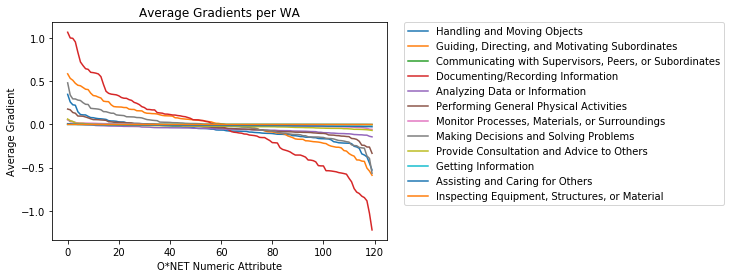

In [352]:
display = 3
plt.title("Average Gradients per WA")
plt.ylabel("Average Gradient")
plt.xlabel("O*NET Numeric Attribute")

for wa, grads in local_AGs.items():
    if counts[wa] < 10: continue
    text = WAref[WAref['WA ID']==wa].reset_index()['WA Title'][0]
    print("\n", wa, text)
#     if wa != "4.A.2.a.3": continue
        
    l = [y[2] for y in sorted(grads, key=lambda x: x[2])][::-1]
    a = plt.plot(range(len(cols)), l, label= text)

    print("positive")
    for i in [y for y in sorted(grads, key=lambda x: x[2])[-display:]][::-1]:
        print(i)
    print("negative")
    for i in [y for y in sorted(grads, key=lambda x: x[2])[:display]]:
        print(i)
        
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Global average Gradients:

positive
('Depth Perception', 73, 0.26219139193594226)
('Sociology and Anthropology', 64, 0.2466968388231059)
('Explosive Strength', 76, 0.24395722063984165)
('Multilimb Coordination', 91, 0.2163968536938187)
('Response Orientation', 103, 0.1980761421791973)
negative
('Production and Processing', 60, -0.36603709777444504)
('Transportation', 67, -0.27622645174202837)
('Repairing', 24, -0.2730114313861469)
('Mechanical', 55, -0.2716295553073846)
('History and Archeology', 52, -0.27010175603829495)


/home/scpd/Software/anaconda3/envs/GPflow3.5/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


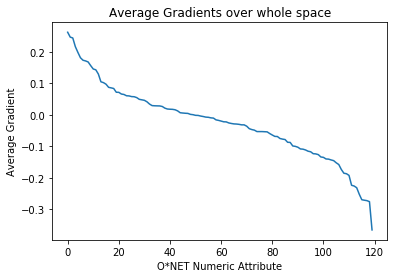

In [353]:
df_subset = df[cols].values
n = df_subset.shape[0]
y_subset = y.reshape(n,)
    
grads_at = m.compute_posterior_grad_at(df_subset)[0]
a_grad = grads_at.mean(axis=0)

display = 5
plt.title("Average Gradients over whole space")
plt.ylabel("Average Gradient")
plt.xlabel("O*NET Numeric Attribute")

global_AGs = [ (cols[cnt], cnt, i)  for cnt, i in enumerate(a_grad)]

l = [y[2] for y in sorted(global_AGs, key=lambda x: x[2])][::-1]
a = plt.plot(range(len(cols)), l, label= text)

print("positive")
for i in [y for y in sorted(global_AGs, key=lambda x: x[2])[-display:]][::-1]:
    print(i)
print("negative")
for i in [y for y in sorted(global_AGs, key=lambda x: x[2])[:display]]:
    print(i)

In [354]:
# # Output the average gradients for logan: 

all_AGs = copy.copy(local_AGs)
all_AGs['Global_Averages'] = global_AGs


path = os.path.join(datasets, 'FoEmployment/Analysis_of_ONET_Tasks', 'average_gradients_RBF_per_IWA.p')
f = open(path, "wb")
pickle.dump(all_AGs, f)
f.close()

# sorted_AGs['4.A.1.a.1']